In [1]:
import h5py
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import models,layers
from tensorflow.keras import regularizers
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Input
from tensorflow.keras.losses import Huber
from tensorflow.keras.optimizers import Adam

In [2]:
# open HDF5 file

f1 = h5py.File("./cushion_twophase100x100x50v5.h5", 'r')
f2 = h5py.File("./cushion_twophase100x100x100v0.005.h5", 'r')
f3 = h5py.File("./cushion_twophase200x200x100v0.005.h5", 'r')
f4 = h5py.File("./cushion_twophase200x200x100v0.005.h5", 'r')
f5 = h5py.File("./cushion_twophase200x200x100v0.05.h5", 'r')
f6 = h5py.File("./cushion_twophase200x200x100v5.h5", 'r')
f7 = h5py.File("./cushion_twophase200x200x100v5000.h5", 'r')

f_all = [f1,f2,f3,f4,f5,f6,f7]

template_paths = [
    "Function/CS/{i}", "Function/FS/{i}", "Function/JS/{i}",
    "Function/KF/{i}", "Function/P_S/{i}", "Function/S_S/{i}", 
    "Function/T_S/{i}", "Function/eigS1_CS/{i}", "Function/eigS2_CS/{i}", 
    "Function/eigS3_CS/{i}", "Function/gradp/{i}", "Function/nS/{i}",
    "Function/p/{i}", "Function/rhoFR/{i}", "Function/uS/{i}",
    "Function/wFR/{i}", "Mesh/mesh/geometry", "Mesh/mesh/topology"]

functions = ["Function/CS", "Function/FS", "Function/JS",
"Function/KF", "Function/P_S", "Function/S_S", 
"Function/T_S", "Function/eigS1_CS", "Function/eigS2_CS", 
"Function/eigS3_CS", "Function/gradp", "Function/nS",
"Function/p", "Function/rhoFR", "Function/uS",
"Function/wFR"]

In [3]:
def call_all(f):
    path_all = []
    def read_all(name, obj):
        if not "topology" in name: #filter
            path_all.append(name)
    f.visititems(read_all)
    return path_all

final_results = []

for index, f in enumerate(f_all): #loop f1 to f7
    print(f"\nProcessing file: {f}\nfile: {index+1}")
    path_all = call_all(f) #f1 to f

    file_results = [] #store all f

    # Collect time steps from all files
    time_steps = set()
    for path in path_all:
        if "CS" in path and path.count("/") > 1:
            time_step = path.split('/')[-1] # Extract the time step from the path
            time_steps.add(time_step)  # Add time step to the set      
    time_steps = sorted(time_steps) # Convert the set to a sorted list
    print(f"\nNumber of time steps file: {len(time_steps)}")

    # Loop through each time step
    for time_step in time_steps:
        feature_list = []  # List to hold matrices for the current time step

        # Loop through each function
        for function in functions:
            function_path = f"{function}/{time_step}"
            if function_path in path_all:
                matrix = f[function_path][:] #fi to f
                
            feature_list.append(matrix)
            #print(f"path: {function_path}, shape: {matrix.shape}")

        # Horizontally stack matrices for the current time step
        if feature_list:
            stacked_features = np.hstack(feature_list)
            #print(f"path: {function_path}, shape: {stacked_features.shape}")
            file_results.append(stacked_features)

    # Vertically stack the final results
    if file_results:
        file_matrix = np.vstack(file_results)
        #print(f"\nFinal stacked matrix shape: {file_matrix.shape}")
        final_results.append(file_matrix)

# Vertically stack the final results from all files
if final_results:
    final_matrix = np.vstack(final_results)
    x_in = final_matrix
    print(f"\nFinal stacked matrix shape (x): {x_in.shape}")


Processing file: <HDF5 file "cushion_twophase100x100x50v5.h5" (mode r)>
file: 1

Number of time steps file: 49

Processing file: <HDF5 file "cushion_twophase100x100x100v0.005.h5" (mode r)>
file: 2

Number of time steps file: 77

Processing file: <HDF5 file "cushion_twophase200x200x100v0.005.h5" (mode r)>
file: 3

Number of time steps file: 79

Processing file: <HDF5 file "cushion_twophase200x200x100v0.005.h5" (mode r)>
file: 4

Number of time steps file: 79

Processing file: <HDF5 file "cushion_twophase200x200x100v0.05.h5" (mode r)>
file: 5

Number of time steps file: 66

Processing file: <HDF5 file "cushion_twophase200x200x100v5.h5" (mode r)>
file: 6

Number of time steps file: 49

Processing file: <HDF5 file "cushion_twophase200x200x100v5000.h5" (mode r)>
file: 7

Number of time steps file: 49

Final stacked matrix shape (x): (529984, 62)


In [4]:
# Call all dunction
def call_all(f):
    path_all = []
    def read_all(name, obj):
        if not "topology" in name: #filter
            path_all.append(name)
    f.visititems(read_all)
    return path_all

# Collect time steps from all files
time_steps = set()
for f in f_all:
    path_all = call_all(f)
    for path in path_all:
        if "CS" in path and path.count("/") > 1:
            time_step = path.split('/')[-1] # Extract the time step from the path
            time_steps.add(time_step)  # Add time step to the set
        
time_steps = sorted(time_steps) # Convert the set to a sorted list
print(f"Number of time steps: {len(time_steps)}\n")

results = []
input_x = []  # input matrix
output_y = []  # output matrix

#all files
for index, f in enumerate(f_all):
    print(f"File {index+1}:")

    path_all = call_all(f)
    uS_results = []  #"Function/uS/{i}"
    feature_i = []
    
    for path in path_all:
        if path.count("/") < 2:
            continue

        matrix = f[path][()]

        if "uS" in path:
            uS_results.append(matrix)
            print(f"uS: f{index+1}[\"{path}\"], shape: {np.shape(uS_results)}")
    
    if uS_results:
        uS_matrix = np.vstack(uS_results)
        output_y.append(uS_matrix)     

print(f"\nNumber of uS matrices: {len(uS_results)}")

y_out = np.vstack(output_y)
y = y_out
print(f"final output matrix shape (y): {y.shape}")

Number of time steps: 282

File 1:
uS: f1["Function/uS/0_10000000000000001"], shape: (1, 1183, 3)
uS: f1["Function/uS/0_20000000000000001"], shape: (2, 1183, 3)
uS: f1["Function/uS/0_30000000000000004"], shape: (3, 1183, 3)
uS: f1["Function/uS/0_40000000000000002"], shape: (4, 1183, 3)
uS: f1["Function/uS/0_5"], shape: (5, 1183, 3)
uS: f1["Function/uS/0_59999999999999998"], shape: (6, 1183, 3)
uS: f1["Function/uS/0_69999999999999996"], shape: (7, 1183, 3)
uS: f1["Function/uS/0_79999999999999993"], shape: (8, 1183, 3)
uS: f1["Function/uS/0_89999999999999991"], shape: (9, 1183, 3)
uS: f1["Function/uS/0_99999999999999989"], shape: (10, 1183, 3)
uS: f1["Function/uS/1_0999999999999999"], shape: (11, 1183, 3)
uS: f1["Function/uS/1_2"], shape: (12, 1183, 3)
uS: f1["Function/uS/1_3"], shape: (13, 1183, 3)
uS: f1["Function/uS/1_4000000000000001"], shape: (14, 1183, 3)
uS: f1["Function/uS/1_5000000000000002"], shape: (15, 1183, 3)
uS: f1["Function/uS/1_6000000000000003"], shape: (16, 1183, 3)
uS

In [5]:
#Data Cleaning
#Check for NaN or Inf values in the final matrix
if np.isnan(x_in).any() or np.isinf(x_in).any():
    print("NaN or Inf values in the matrix.")
    x_in = np.nan_to_num(final_matrix, nan=0.0, posinf=0.0, neginf=0.0) #Replace NaN with 0

scalerx = MinMaxScaler()
#Normalize x
x = scalerx.fit_transform(x_in)
print(f"\nFinal normalized matrix shape (x): {x.shape}")
print(f"{x[1]}")

NaN or Inf values in the matrix.

Final normalized matrix shape (x): (529984, 62)
[2.74167635e-01 8.36646749e-01 4.58900810e-01 8.36646749e-01
 2.74167635e-01 4.58900810e-01 4.58900810e-01 4.58900810e-01
 5.22150742e-01 7.86508483e-01 8.65063281e-01 5.22277881e-01
 8.65063281e-01 7.86508483e-01 5.22277881e-01 5.00000000e-01
 5.00000000e-01 8.17211681e-01 6.86664044e-01 1.00000000e+00
 9.99985867e-01 8.75885926e-05 1.14761953e-04 8.75885926e-05
 9.99985867e-01 1.14761953e-04 5.00000000e-01 4.99999999e-01
 9.76514346e-01 1.00000000e+00 9.99088372e-01 5.00000000e-01
 9.99088372e-01 1.00000000e+00 4.99999999e-01 5.00000000e-01
 4.99999999e-01 1.00000000e+00 9.99999999e-01 3.07662541e-01
 6.03804247e-01 3.07662541e-01 9.99999999e-01 6.03804247e-01
 6.03804247e-01 6.03804247e-01 9.99999999e-01 9.64274481e-03
 9.17931770e-01 2.09727146e-01 2.22265090e-01 2.22265090e-01
 5.00000000e-01 1.83948690e-12 2.14241958e-11 2.14243068e-11
 1.00000000e+00 1.00000000e+00 1.00000000e+00 9.27302826e-01
 9.

In [6]:
#divide our test array
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.8,random_state=20)

In [7]:
# initialize a object named model from Tensorflow Sequential model class.
model = Sequential()

## Feedforward Neural Network (FFNN) - simple
# Input Layer
model.add(Input(shape=(x_train.shape[1],))) 

# Hidden Layer 
model.add(LSTM(64, activation='softplus'))  
model.add(Dense(32, activation='softplus'))  
model.add(Dense(16, activation='softplus'))  

# Output Layer
model.add(Dense(1, activation='linear'))  # for regression problem as it predict continuous numerical variable

In [8]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 256)                 │          16,128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 16)                  │             528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 1)                   │              17 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 59,905 (234.00 KB)

 Trainable params: 59,905 (234.00 KB)

 Non-trainable params: 0 (0.00 B)

In [55]:
# Compile the built model with optimizer, loss and metrics

adam = tf.keras.optimizers.Adam(learning_rate=0.00002)

model.compile(optimizer='adam', loss='huber', metrics=['mse','mae'])
#Huber loss to deal with noise, mesh irregularities, learns better from small errors while reducing the impact of large deviations.



In [57]:
history = model.fit(x_train,y_train,epochs=50,batch_size=32,validation_data=(x_test,y_test))

Epoch 1/50
3313/3313 ━━━━━━━━━━━━━━━━━━━━ 25s 7ms/step - loss: 5.1392 - mae: 5.5557 - mse: 137.2197 - val_loss: 4.6962 - val_mae: 5.1075 - val_mse: 131.1627
Epoch 2/50
3313/3313 ━━━━━━━━━━━━━━━━━━━━ 23s 7ms/step - loss: 4.6739 - mae: 5.0558 - mse: 131.1126 - val_loss: 4.6782 - val_mae: 5.0206 - val_mse: 133.6994
Epoch 3/50
3313/3313 ━━━━━━━━━━━━━━━━━━━━ 22s 7ms/step - loss: 4.6931 - mae: 5.0683 - mse: 133.3137 - val_loss: 4.6659 - val_mae: 5.0261 - val_mse: 131.4567
Epoch 4/50
3313/3313 ━━━━━━━━━━━━━━━━━━━━ 23s 7ms/step - loss: 4.6441 - mae: 5.0171 - mse: 131.0672 - val_loss: 4.6555 - val_mae: 5.0106 - val_mse: 133.1687
Epoch 5/50
3313/3313 ━━━━━━━━━━━━━━━━━━━━ 24s 7ms/step - loss: 4.6698 - mae: 5.0425 - mse: 133.0070 - val_loss: 4.6624 - val_mae: 5.0459 - val_mse: 133.2824
Epoch 6/50
3313/3313 ━━━━━━━━━━━━━━━━━━━━ 24s 7ms/step - loss: 4.6702 - mae: 5.0435 - mse: 132.9736 - val_loss: 4.6698 - val_mae: 5.0708 - val_mse: 130.6213
Epoch 7/50
3313/3313 ━━━━━━━━━━━━━━━━━━━━ 23s 7ms/step - l

In [59]:
hist = pd.DataFrame(history.history)
hist.head()

,loss,mae,mse,val_loss,val_mae,val_mse
0,4.859424,5.256647,132.928055,4.696185,5.107527,131.162689
1,4.681908,5.061311,131.936600,4.678229,5.020641,133.699432
2,4.667840,5.042246,131.946777,4.665931,5.026132,131.456711
3,4.659448,5.032761,131.911575,4.655497,5.010572,133.168747
4,4.652323,5.024982,131.926147,4.662417,5.045884,133.282410


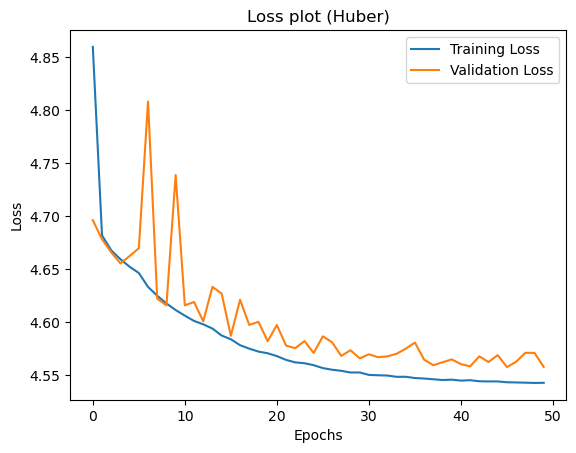

In [61]:
plt.title('Loss plot (Huber)')
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

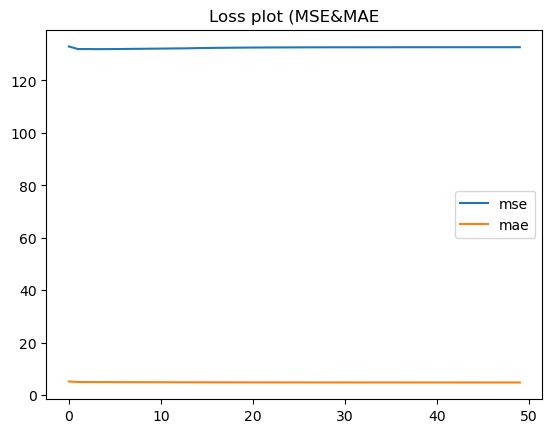

In [63]:
plt.title('Loss plot (MSE&MAE')
plt.plot(hist['mse'], label='mse')
plt.plot(hist['mae'], label='mae')
plt.legend()